# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import vaep
import vaep.analyzers
import vaep.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
vaep.plotting.make_large_descriptors(fontsize)


logger = vaep.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "VAE"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = vaep.nb.get_params(args, globals=globals())
args = vaep.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = vaep.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'VAE',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = vaep.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                                
Sample_155  Q5SZK8                                           14.254
Sample_100  A0A0D9SEP4;A0A1D5RMU6;E7ERL8;Q9ULB1-2;Q9ULB1-3   19.070
Sample_162  Q9HDB5                                           18.714
Sample_006  P35749;P35749-2;P35749-3;P35749-4                21.034
Sample_174  P41217;P41217-2;P41217-3;U3KQG5                  16.971
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = vaep.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[vaep.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = vaep.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by VAE: runs/alzheimer_study/preds/pred_real_na_VAE.csv


Sample ID   protein groups          
Sample_105  B4DGQ7;P21860;P21860-4     13.101
Sample_039  Q96AQ6;Q96AQ6-2            14.459
Sample_015  Q8TDF5;Q8TDF5-1;Q8TDF5-2   15.979
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 11.698
            A0A075B6Q5                 11.606
            A0A075B6R2                 13.068
            A0A075B6S5                 13.623
            A0A087WSY4                 13.272
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   11.434
            Q9UI40;Q9UI40-2            12.672
            Q9UIW2                     12.425
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.199
            Q9UP79                     12.618
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.091,15.050,16.842,19.863,16.022,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.734,19.067,...,15.528,15.576,14.033,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.957,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.617,17.705,17.039,16.207,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.708,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.390,15.345,17.084,18.708,14.249,19.433,11.068,11.338
Sample_207,15.739,16.877,15.469,16.898,15.600,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,11.698,...,16.012,15.178,12.706,15.050,16.842,19.863,12.769,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,11.862,19.067,16.188,...,15.528,15.576,11.936,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,12.926,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,13.027,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.378,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,12.919,15.345,17.084,18.708,14.249,19.433,12.183,12.181
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 298.74it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.29it/s]

100%|██████████| 2/2 [00:00<00:00,  5.26it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  4.35it/s]

100%|██████████| 3/3 [00:00<00:00,  3.18it/s]

100%|██████████| 3/3 [00:00<00:00,  3.35it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  3.20it/s]

 75%|███████▌  | 3/4 [00:01<00:00,  2.30it/s]

100%|██████████| 4/4 [00:01<00:00,  2.03it/s]

100%|██████████| 4/4 [00:01<00:00,  2.18it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  4.36it/s]

 60%|██████    | 3/5 [00:00<00:00,  2.85it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.59it/s]

100%|██████████| 5/5 [00:01<00:00,  2.50it/s]

100%|██████████| 5/5 [00:01<00:00,  2.69it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.38it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.69it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.13it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.48it/s]

100%|██████████| 6/6 [00:02<00:00,  2.20it/s]

100%|██████████| 6/6 [00:02<00:00,  2.61it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  6.12it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.48it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  3.87it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.51it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  2.85it/s]

100%|██████████| 7/7 [00:02<00:00,  2.38it/s]

100%|██████████| 7/7 [00:02<00:00,  2.97it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.15it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.73it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.19it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.92it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.55it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.29it/s]

100%|██████████| 8/8 [00:03<00:00,  2.09it/s]

100%|██████████| 8/8 [00:03<00:00,  2.55it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  6.30it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.63it/s]

 44%|████▍     | 4/9 [00:00<00:01,  3.82it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.07it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.13it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.75it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.58it/s]

100%|██████████| 9/9 [00:03<00:00,  2.35it/s]

100%|██████████| 9/9 [00:03<00:00,  2.88it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  7.01it/s]

 30%|███       | 3/10 [00:00<00:01,  4.26it/s]

 40%|████      | 4/10 [00:00<00:01,  3.95it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.02it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.04it/s]

 70%|███████   | 7/10 [00:02<00:00,  3.12it/s]

 80%|████████  | 8/10 [00:02<00:00,  3.18it/s]

 90%|█████████ | 9/10 [00:02<00:00,  2.86it/s]

100%|██████████| 10/10 [00:03<00:00,  2.45it/s]

100%|██████████| 10/10 [00:03<00:00,  3.02it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  6.17it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.57it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.06it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.27it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.00it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.18it/s]

 73%|███████▎  | 8/11 [00:02<00:00,  3.25it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.03it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.66it/s]

100%|██████████| 11/11 [00:03<00:00,  2.48it/s]

100%|██████████| 11/11 [00:03<00:00,  3.04it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.48it/s]

 25%|██▌       | 3/12 [00:00<00:02,  4.33it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.69it/s]

 42%|████▏     | 5/12 [00:01<00:01,  3.51it/s]

 50%|█████     | 6/12 [00:01<00:02,  2.99it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.98it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  3.03it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.17it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.99it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  2.58it/s]

100%|██████████| 12/12 [00:04<00:00,  2.31it/s]

100%|██████████| 12/12 [00:04<00:00,  2.92it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  7.38it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.99it/s]

 31%|███       | 4/13 [00:00<00:02,  4.16it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.53it/s]

 46%|████▌     | 6/13 [00:01<00:02,  2.98it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.96it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  3.03it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.09it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  3.05it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.64it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  2.39it/s]

100%|██████████| 13/13 [00:04<00:00,  2.28it/s]

100%|██████████| 13/13 [00:04<00:00,  2.90it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  6.27it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.43it/s]

 29%|██▊       | 4/14 [00:00<00:02,  3.90it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.48it/s]

 43%|████▎     | 6/14 [00:01<00:02,  2.92it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.90it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.77it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  2.88it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.95it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.60it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.35it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.22it/s]

100%|██████████| 14/14 [00:05<00:00,  2.26it/s]

100%|██████████| 14/14 [00:05<00:00,  2.76it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  6.31it/s]

 20%|██        | 3/15 [00:00<00:02,  4.49it/s]

 27%|██▋       | 4/15 [00:00<00:02,  3.71it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.55it/s]

 40%|████      | 6/15 [00:01<00:02,  3.05it/s]

 47%|████▋     | 7/15 [00:02<00:02,  3.10it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.95it/s]

 60%|██████    | 9/15 [00:02<00:02,  2.89it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.86it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.96it/s]

 80%|████████  | 12/15 [00:03<00:01,  2.54it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.40it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  2.27it/s]

100%|██████████| 15/15 [00:05<00:00,  2.16it/s]

100%|██████████| 15/15 [00:05<00:00,  2.76it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.004      0.058 0.026          0.705 0.393       0.098   
2             0.004 0.003      0.059 0.021          0.666 0.100       0.529   
3             0.004 0.002      0.051 0.016          0.758 0.095       0.674   
4             0.005 0.004      0.068 0.030          0.754 0.094       0.712   
5             0.004 0.002      0.056 0.018          0.795 0.083       0.738   
6             0.007 0.006      0.067 0.028          0.811 0.079       0.743   
7             0.007 0.005      0.076 0.032          0.811 0.082       0.747   
8             0.004 0.002      0.057 0.018          0.820 0.083       0.833   
9             0.004 0.002      0.058 0.018          0.823 0.081       0.837   
10            0.005 0.004      0.063 0.026          0.827 0.080       0.831   
11            0.004 0.004      0.049 0.021          0.816 0.086       0.822   
12            0.005 0.003      0.063 0.023          0.813 0.089       0.821   
13            0.005 0.004      0.055 0.018          0.810 0.084       0.819   
14            0.004 0.002      0.057 0.016          0.805 0.083       0.818   
15            0.004 0.002      0.051 0.012          0.820 0.073       0.810   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.078   0.167 0.120                  0.542 0.036        0.850   
2          0.107   0.581 0.077                  0.663 0.052        0.730   
3          0.124   0.707 0.088                  0.756 0.069        0.830   
4          0.131   0.724 0.089                  0.769 0.069        0.842   
5          0.090   0.761 0.066                  0.798 0.053        0.858   
6          0.082   0.772 0.061                  0.807 0.050        0.865   
7          0.089   0.773 0.064                  0.808 0.052        0.863   
8          0.098   0.822 0.065                  0.848 0.056        0.910   
9          0.103   0.825 0.069                  0.851 0.060        0.910   
10         0.103   0.824 0.066                  0.850 0.056        0.909   
11         0.109   0.813 0.073                  0.841 0.062        0.907   
12         0.109   0.812 0.075                  0.840 0.064        0.906   
13         0.103   0.810 0.071                  0.837 0.061        0.904   
14         0.103   0.807 0.072                  0.835 0.062        0.903   
15         0.104   0.810 0.068                  0.839 0.057        0.909   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.064                  0.823 0.089        210.000 0.000  
2          0.073                  0.669 0.090        210.000 0.000  
3          0.065                  0.807 0.079        210.000 0.000  
4          0.061                  0.826 0.065        210.000 0.000  
5          0.061                  0.846 0.069        210.000 0.000  
6          0.062                  0.846 0.072        210.000 0.000  
7          0.062                  0.844 0.071        210.000 0.000  
8          0.049                  0.899 0.050        210.000 0.000  
9          0.050                  0.900 0.051        210.000 0.000  
10         0.050                  0.896 0.054        210.000 0.000  
11         0.051                  0.894 0.054        210.000 0.000  
12         0.051                  0.894 0.053        210.000 0.000  
13         0.052                  0.890 0.055        210.000 0.000  
14         0.051                  0.888 0.055        210.000 0.000  
15         0.050                  0.891 0.055 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 498.08it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  4.78it/s]

100%|██████████| 2/2 [00:00<00:00,  4.75it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  2.89it/s]

100%|██████████| 3/3 [00:01<00:00,  2.15it/s]

100%|██████████| 3/3 [00:01<00:00,  2.24it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  3.45it/s]

 75%|███████▌  | 3/4 [00:01<00:00,  2.76it/s]

100%|██████████| 4/4 [00:01<00:00,  2.51it/s]

100%|██████████| 4/4 [00:01<00:00,  2.66it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  4.04it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.23it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.08it/s]

100%|██████████| 5/5 [00:01<00:00,  3.10it/s]

100%|██████████| 5/5 [00:01<00:00,  3.20it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:01,  3.46it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.48it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.43it/s]

 83%|████████▎ | 5/6 [00:02<00:00,  2.18it/s]

100%|██████████| 6/6 [00:02<00:00,  2.17it/s]

100%|██████████| 6/6 [00:02<00:00,  2.33it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.45it/s]

 43%|████▎     | 3/7 [00:00<00:01,  2.71it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.34it/s]

 71%|███████▏  | 5/7 [00:02<00:00,  2.21it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  1.96it/s]

100%|██████████| 7/7 [00:03<00:00,  1.79it/s]

100%|██████████| 7/7 [00:03<00:00,  2.11it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  6.29it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.06it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.12it/s]

 62%|██████▎   | 5/8 [00:02<00:01,  1.85it/s]

 75%|███████▌  | 6/8 [00:02<00:01,  1.85it/s]

 88%|████████▊ | 7/8 [00:03<00:00,  1.94it/s]

100%|██████████| 8/8 [00:03<00:00,  2.05it/s]

100%|██████████| 8/8 [00:03<00:00,  2.16it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  6.08it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.08it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.49it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.74it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.28it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.09it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  1.98it/s]

100%|██████████| 9/9 [00:03<00:00,  2.21it/s]

100%|██████████| 9/9 [00:03<00:00,  2.50it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.69it/s]

 30%|███       | 3/10 [00:00<00:01,  4.02it/s]

 40%|████      | 4/10 [00:01<00:01,  3.57it/s]

 50%|█████     | 5/10 [00:01<00:01,  2.61it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.08it/s]

 70%|███████   | 7/10 [00:03<00:01,  1.79it/s]

 80%|████████  | 8/10 [00:03<00:01,  1.65it/s]

 90%|█████████ | 9/10 [00:04<00:00,  1.69it/s]

100%|██████████| 10/10 [00:04<00:00,  1.85it/s]

100%|██████████| 10/10 [00:04<00:00,  2.12it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  4.57it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.54it/s]

 36%|███▋      | 4/11 [00:01<00:01,  3.65it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.15it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  2.46it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.22it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  2.11it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.02it/s]

 91%|█████████ | 10/11 [00:04<00:00,  2.03it/s]

100%|██████████| 11/11 [00:04<00:00,  2.16it/s]

100%|██████████| 11/11 [00:04<00:00,  2.42it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  4.87it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.64it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.48it/s]

 42%|████▏     | 5/12 [00:01<00:02,  3.32it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.18it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  3.07it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.52it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.31it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.08it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  1.99it/s]

100%|██████████| 12/12 [00:04<00:00,  2.08it/s]

100%|██████████| 12/12 [00:04<00:00,  2.53it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  5.55it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.10it/s]

 31%|███       | 4/13 [00:01<00:02,  3.50it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.23it/s]

 46%|████▌     | 6/13 [00:01<00:02,  3.07it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.89it/s]

 62%|██████▏   | 8/13 [00:02<00:02,  2.02it/s]

 69%|██████▉   | 9/13 [00:03<00:02,  1.73it/s]

 77%|███████▋  | 10/13 [00:04<00:01,  1.62it/s]

 85%|████████▍ | 11/13 [00:04<00:01,  1.71it/s]

 92%|█████████▏| 12/13 [00:05<00:00,  1.85it/s]

100%|██████████| 13/13 [00:05<00:00,  2.00it/s]

100%|██████████| 13/13 [00:05<00:00,  2.24it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:03,  3.35it/s]

 21%|██▏       | 3/14 [00:01<00:04,  2.40it/s]

 29%|██▊       | 4/14 [00:01<00:04,  2.07it/s]

 36%|███▌      | 5/14 [00:02<00:04,  2.18it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.18it/s]

 50%|█████     | 7/14 [00:03<00:03,  2.19it/s]

 57%|█████▋    | 8/14 [00:03<00:02,  2.09it/s]

 64%|██████▍   | 9/14 [00:04<00:02,  1.93it/s]

 71%|███████▏  | 10/14 [00:04<00:02,  1.88it/s]

 79%|███████▊  | 11/14 [00:05<00:01,  1.90it/s]

 86%|████████▌ | 12/14 [00:05<00:01,  2.00it/s]

 93%|█████████▎| 13/14 [00:06<00:00,  2.11it/s]

100%|██████████| 14/14 [00:06<00:00,  2.24it/s]

100%|██████████| 14/14 [00:06<00:00,  2.14it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.51it/s]

 20%|██        | 3/15 [00:00<00:03,  3.42it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.10it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.83it/s]

 40%|████      | 6/15 [00:02<00:03,  2.74it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.53it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.65it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.42it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.52it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.61it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.73it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.81it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  2.98it/s]

100%|██████████| 15/15 [00:05<00:00,  3.14it/s]

100%|██████████| 15/15 [00:05<00:00,  2.86it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.004      0.058 0.021          0.010 0.071       0.001   
2             0.005 0.003      0.056 0.017          0.720 0.087       0.555   
3             0.005 0.005      0.060 0.022          0.705 0.090       0.570   
4             0.004 0.000      0.048 0.010          0.687 0.089       0.589   
5             0.004 0.002      0.045 0.008          0.736 0.084       0.608   
6             0.004 0.003      0.046 0.014          0.727 0.091       0.612   
7             0.007 0.006      0.079 0.036          0.791 0.092       0.791   
8             0.005 0.004      0.059 0.021          0.782 0.088       0.798   
9             0.005 0.003      0.069 0.031          0.777 0.095       0.791   
10            0.005 0.003      0.057 0.021          0.796 0.095       0.772   
11            0.005 0.004      0.062 0.029          0.795 0.087       0.773   
12            0.007 0.006      0.072 0.026          0.803 0.092       0.781   
13            0.005 0.005      0.054 0.017          0.801 0.093       0.770   
14            0.005 0.003      0.063 0.028          0.829 0.094       0.773   
15            0.004 0.003      0.049 0.024          0.835 0.089       0.783   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.008   0.002 0.015                  0.497 0.008        0.860   
2          0.109   0.621 0.087                  0.698 0.056        0.781   
3          0.114   0.623 0.086                  0.696 0.055        0.779   
4          0.108   0.627 0.079                  0.694 0.054        0.777   
5          0.108   0.658 0.071                  0.721 0.049        0.794   
6          0.111   0.658 0.076                  0.719 0.055        0.797   
7          0.116   0.785 0.075                  0.816 0.064        0.895   
8          0.116   0.785 0.079                  0.816 0.067        0.895   
9          0.114   0.779 0.083                  0.811 0.070        0.893   
10         0.118   0.777 0.081                  0.811 0.067        0.908   
11         0.122   0.778 0.082                  0.812 0.067        0.914   
12         0.117   0.786 0.079                  0.818 0.065        0.916   
13         0.118   0.778 0.078                  0.812 0.064        0.915   
14         0.101   0.795 0.077                  0.827 0.063        0.918   
15         0.103   0.804 0.076                  0.834 0.062        0.919   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.061                  0.828 0.086        210.000 0.000  
2          0.066                  0.749 0.086        210.000 0.000  
3          0.065                  0.743 0.084        210.000 0.000  
4          0.064                  0.729 0.084        210.000 0.000  
5          0.065                  0.761 0.086        210.000 0.000  
6          0.065                  0.755 0.088        210.000 0.000  
7          0.051                  0.862 0.066        210.000 0.000  
8          0.052                  0.865 0.064        210.000 0.000  
9          0.052                  0.862 0.064        210.000 0.000  
10         0.047                  0.878 0.063        210.000 0.000  
11         0.044                  0.889 0.057        210.000 0.000  
12         0.043                  0.892 0.057        210.000 0.000  
13         0.043                  0.890 0.057        210.000 0.000  
14         0.043                  0.896 0.055        210.000 0.000  
15         0.043                  0.899 0.052 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 881.90it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 25.55it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 15.58it/s]

100%|██████████| 3/3 [00:00<00:00, 15.36it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 18.64it/s]

100%|██████████| 4/4 [00:00<00:00, 16.57it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 14.21it/s]

100%|██████████| 5/5 [00:00<00:00, 11.69it/s]

100%|██████████| 5/5 [00:00<00:00, 11.92it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00, 15.90it/s]

 67%|██████▋   | 4/6 [00:00<00:00, 12.69it/s]

100%|██████████| 6/6 [00:00<00:00, 11.40it/s]

100%|██████████| 6/6 [00:00<00:00, 11.74it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 19.22it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 14.96it/s]

100%|██████████| 7/7 [00:00<00:00, 13.29it/s]

100%|██████████| 7/7 [00:00<00:00, 14.05it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 15.78it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 14.58it/s]

 88%|████████▊ | 7/8 [00:00<00:00, 12.51it/s]

100%|██████████| 8/8 [00:00<00:00, 13.13it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00, 17.07it/s]

 44%|████▍     | 4/9 [00:00<00:00, 12.74it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 12.59it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 12.65it/s]

100%|██████████| 9/9 [00:00<00:00, 12.66it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 13.33it/s]

 50%|█████     | 5/10 [00:00<00:00, 12.82it/s]

 70%|███████   | 7/10 [00:00<00:00, 13.00it/s]

 90%|█████████ | 9/10 [00:00<00:00, 13.25it/s]

100%|██████████| 10/10 [00:00<00:00, 13.27it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00, 18.20it/s]

 36%|███▋      | 4/11 [00:00<00:00, 11.82it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 10.55it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 10.45it/s]

 91%|█████████ | 10/11 [00:00<00:00, 10.26it/s]

100%|██████████| 11/11 [00:01<00:00, 10.98it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 16.75it/s]

 42%|████▏     | 5/12 [00:00<00:00,  9.75it/s]

 58%|█████▊    | 7/12 [00:00<00:00,  9.11it/s]

 67%|██████▋   | 8/12 [00:00<00:00,  9.24it/s]

 75%|███████▌  | 9/12 [00:00<00:00,  8.85it/s]

 83%|████████▎ | 10/12 [00:01<00:00,  8.79it/s]

100%|██████████| 12/12 [00:01<00:00,  9.22it/s]

100%|██████████| 12/12 [00:01<00:00,  9.49it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 18.27it/s]

 38%|███▊      | 5/13 [00:00<00:00, 14.05it/s]

 54%|█████▍    | 7/13 [00:00<00:00, 12.36it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 12.58it/s]

 85%|████████▍ | 11/13 [00:00<00:00, 12.48it/s]

100%|██████████| 13/13 [00:00<00:00, 13.00it/s]

100%|██████████| 13/13 [00:00<00:00, 13.12it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 18.38it/s]

 36%|███▌      | 5/14 [00:00<00:00, 13.64it/s]

 50%|█████     | 7/14 [00:00<00:00, 12.71it/s]

 64%|██████▍   | 9/14 [00:00<00:00, 12.23it/s]

 79%|███████▊  | 11/14 [00:00<00:00, 12.07it/s]

 93%|█████████▎| 13/14 [00:01<00:00, 12.15it/s]

100%|██████████| 14/14 [00:01<00:00, 12.71it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:00, 19.34it/s]

 27%|██▋       | 4/15 [00:00<00:00, 11.12it/s]

 40%|████      | 6/15 [00:00<00:00, 10.07it/s]

 53%|█████▎    | 8/15 [00:00<00:00,  9.75it/s]

 67%|██████▋   | 10/15 [00:01<00:00,  8.92it/s]

 73%|███████▎  | 11/15 [00:01<00:00,  8.84it/s]

 87%|████████▋ | 13/15 [00:01<00:00,  9.19it/s]

100%|██████████| 15/15 [00:01<00:00,  9.76it/s]

100%|██████████| 15/15 [00:01<00:00,  9.76it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.004      0.050 0.012          0.000 0.000       0.000   
2             0.004 0.003      0.061 0.022          0.673 0.132       0.466   
3             0.004 0.002      0.058 0.025          0.675 0.127       0.477   
4             0.004 0.001      0.046 0.007          0.659 0.127       0.465   
5             0.006 0.006      0.061 0.023          0.659 0.134       0.476   
6             0.004 0.002      0.050 0.011          0.628 0.119       0.472   
7             0.006 0.004      0.061 0.018          0.658 0.100       0.579   
8             0.005 0.003      0.055 0.016          0.654 0.100       0.576   
9             0.004 0.003      0.059 0.022          0.681 0.086       0.613   
10            0.004 0.001      0.054 0.019          0.674 0.092       0.600   
11            0.004 0.002      0.050 0.011          0.679 0.087       0.606   
12            0.005 0.004      0.056 0.019          0.678 0.087       0.602   
13            0.006 0.005      0.065 0.020          0.681 0.090       0.609   
14            0.005 0.004      0.065 0.023          0.680 0.084       0.643   
15            0.006 0.005      0.059 0.019          0.674 0.077       0.642   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.751   
2          0.107   0.545 0.106                  0.650 0.068        0.719   
3          0.107   0.553 0.101                  0.653 0.066        0.711   
4          0.106   0.539 0.102                  0.643 0.064        0.710   
5          0.107   0.546 0.104                  0.646 0.067        0.705   
6          0.120   0.531 0.105                  0.633 0.066        0.717   
7          0.114   0.609 0.091                  0.677 0.070        0.781   
8          0.111   0.606 0.089                  0.674 0.069        0.777   
9          0.117   0.639 0.089                  0.701 0.066        0.795   
10         0.109   0.629 0.088                  0.693 0.065        0.790   
11         0.101   0.635 0.080                  0.697 0.060        0.787   
12         0.106   0.633 0.085                  0.696 0.063        0.785   
13         0.113   0.637 0.089                  0.699 0.066        0.784   
14         0.116   0.657 0.090                  0.711 0.071        0.796   
15         0.113   0.653 0.084                  0.708 0.065        0.792   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.065                  0.691 0.084        210.000 0.000  
2          0.072                  0.688 0.083        210.000 0.000  
3          0.074                  0.679 0.082        210.000 0.000  
4          0.074                  0.673 0.088        210.000 0.000  
5          0.074                  0.677 0.089        210.000 0.000  
6          0.070                  0.677 0.083        210.000 0.000  
7          0.058                  0.730 0.067        210.000 0.000  
8          0.060                  0.728 0.067        210.000 0.000  
9          0.060                  0.742 0.069        210.000 0.000  
10         0.061                  0.737 0.070        210.000 0.000  
11         0.063                  0.731 0.073        210.000 0.000  
12         0.063                  0.727 0.075        210.000 0.000  
13         0.064                  0.720 0.077        210.000 0.000  
14         0.065                  0.739 0.080        210.000 0.000  
15         0.065                  0.734 0.080 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,6,12,15
score_time,7,7,13
test_precision,10,15,9
test_recall,9,8,14
test_f1,9,15,14
test_balanced_accuracy,9,15,14
test_roc_auc,9,15,14
test_average_precision,9,15,9
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_ald_full, fname)

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:03,  4.12it/s]

 20%|██        | 3/15 [00:00<00:03,  3.02it/s]

 27%|██▋       | 4/15 [00:01<00:04,  2.74it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.62it/s]

 40%|████      | 6/15 [00:02<00:04,  2.22it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.03it/s]

 53%|█████▎    | 8/15 [00:03<00:03,  2.04it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.10it/s]

 67%|██████▋   | 10/15 [00:04<00:02,  2.23it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.22it/s]

 80%|████████  | 12/15 [00:05<00:01,  2.07it/s]

 87%|████████▋ | 13/15 [00:05<00:01,  1.86it/s]

 93%|█████████▎| 14/15 [00:06<00:00,  1.91it/s]

100%|██████████| 15/15 [00:07<00:00,  1.81it/s]

100%|██████████| 15/15 [00:07<00:00,  2.13it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 15.36it/s]

 36%|███▌      | 5/14 [00:00<00:00, 14.06it/s]

 50%|█████     | 7/14 [00:00<00:00, 11.51it/s]

 64%|██████▍   | 9/14 [00:00<00:00, 11.74it/s]

 79%|███████▊  | 11/14 [00:00<00:00, 10.99it/s]

 93%|█████████▎| 13/14 [00:01<00:00, 11.67it/s]

100%|██████████| 14/14 [00:01<00:00, 12.00it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  6.13it/s]

 33%|███▎      | 3/9 [00:00<00:01,  4.35it/s]

 44%|████▍     | 4/9 [00:00<00:01,  3.73it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.61it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.54it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.47it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.47it/s]

100%|██████████| 9/9 [00:02<00:00,  3.43it/s]

100%|██████████| 9/9 [00:02<00:00,  3.66it/s]

### ROC-AUC on test split

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf


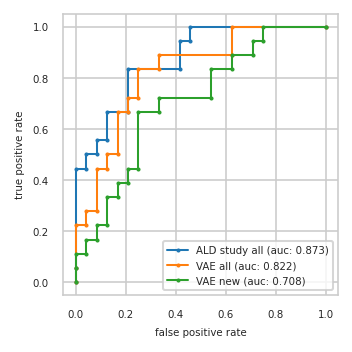

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       VAE all       VAE new      
             fpr   tpr     fpr   tpr     fpr   tpr
0          0.000 0.000   0.000 0.000   0.000 0.000
1          0.000 0.056   0.000 0.056   0.000 0.056
2          0.000 0.444   0.000 0.222   0.000 0.111
3          0.042 0.444   0.042 0.222   0.042 0.111
4          0.042 0.500   0.042 0.278   0.042 0.167
5          0.083 0.500   0.083 0.278   0.083 0.167
6          0.083 0.556   0.083 0.444   0.083 0.222
7          0.125 0.556   0.125 0.444   0.125 0.222
8          0.125 0.667   0.125 0.500   0.125 0.333
9          0.208 0.667   0.167 0.500   0.167 0.333
10         0.208 0.833   0.167 0.667   0.167 0.389
11         0.417 0.833   0.208 0.667   0.208 0.389
12         0.417 0.944   0.208 0.722   0.208 0.444
13         0.458 0.944   0.250 0.722   0.250 0.444
14         0.458 1.000   0.250 0.833   0.250 0.667
15         1.000 1.000   0.333 0.833   0.333 0.667
16           NaN   NaN   0.333 0.889   0.333 0.722
17           NaN   NaN   0.625 0.889   0.542 0.722
18           NaN   NaN   0.625 1.000   0.542 0.833
19           NaN   NaN   1.000 1.000   0.625 0.833
20           NaN   NaN     NaN   NaN   0.625 0.889
21           NaN   NaN     NaN   NaN   0.708 0.889
22           NaN   NaN     NaN   NaN   0.708 0.944
23           NaN   NaN     NaN   NaN   0.750 0.944
24           NaN   NaN     NaN   NaN   0.750 1.000
25           NaN   NaN     NaN   NaN   1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,VAE all,VAE new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,K7ER15;Q9H0R4;Q9H0R4-2,A0A087X1T7;E7EX88;H0YM81;P16112;P16112-2,P51688
2,P02741,P02741,P42262;P42262-2;P42262-3
3,P61981,Q9Y2T3;Q9Y2T3-3,P31321
4,P04075,P63104,A0A0C4DGV4;E9PLX3;O43504;R4GMU8
5,P14174,P04075,Q96GD0
6,P05160,Q96GD0,A0A075B7B8
7,P00338;P00338-3,P61981,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
8,Q9Y2T3;Q9Y2T3-3,P25189;P25189-2,O95297;O95297-2;O95297-3;O95297-4;Q9UEL6


### Precision-Recall plot on test data

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf


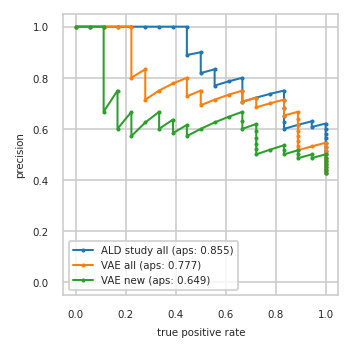

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all         VAE all         VAE new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.500 1.000
7          0.514 1.000     0.514 1.000     0.486 0.944
8          0.529 1.000     0.529 1.000     0.500 0.944
9          0.545 1.000     0.545 1.000     0.485 0.889
10         0.562 1.000     0.531 0.944     0.500 0.889
11         0.581 1.000     0.516 0.889     0.516 0.889
12         0.600 1.000     0.533 0.889     0.500 0.833
13         0.621 1.000     0.552 0.889     0.517 0.833
14         0.607 0.944     0.571 0.889     0.536 0.833
15         0.630 0.944     0.593 0.889     0.519 0.778
16         0.615 0.889     0.615 0.889     0.500 0.722
17         0.600 0.833     0.640 0.889     0.520 0.722
18         0.625 0.833     0.667 0.889     0.542 0.722
19         0.652 0.833     0.652 0.833     0.565 0.722
20         0.682 0.833     0.682 0.833     0.591 0.722
21         0.714 0.833     0.714 0.833     0.619 0.722
22         0.750 0.833     0.700 0.778     0.600 0.667
23         0.737 0.778     0.684 0.722     0.632 0.667
24         0.722 0.722     0.722 0.722     0.667 0.667
25         0.706 0.667     0.706 0.667     0.647 0.611
26         0.750 0.667     0.750 0.667     0.625 0.556
27         0.800 0.667     0.733 0.611     0.600 0.500
28         0.786 0.611     0.714 0.556     0.571 0.444
29         0.769 0.556     0.692 0.500     0.615 0.444
30         0.833 0.556     0.750 0.500     0.583 0.389
31         0.818 0.500     0.727 0.444     0.636 0.389
32         0.900 0.500     0.800 0.444     0.600 0.333
33         0.889 0.444     0.778 0.389     0.667 0.333
34         1.000 0.444     0.750 0.333     0.625 0.278
35         1.000 0.389     0.714 0.278     0.571 0.222
36         1.000 0.333     0.833 0.278     0.667 0.222
37         1.000 0.278     0.800 0.222     0.600 0.167
38         1.000 0.222     1.000 0.222     0.750 0.167
39         1.000 0.167     1.000 0.167     0.667 0.111
40         1.000 0.111     1.000 0.111     1.000 0.111
41         1.000 0.056     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf


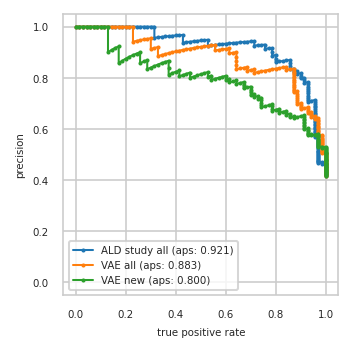

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf


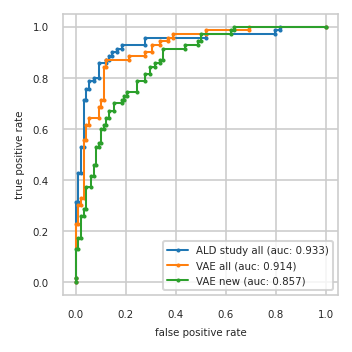

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_VAE all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE all.pkl'),
 'results_VAE new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf')}